In [1]:
#from supportFunctions import *
import cPickle as pickle
from __future__ import division
import numpy as np
from sklearn import tree
#import seaborn as sn
import pandas as pd 

import scipy.cluster.hierarchy as hcluster
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve




In [2]:
class clsf_Performance(object):
    """The performance of a classifier can be evaluated in different manners.

    Attributes:
        y_hat: clf output
        y_test: true values
    """

    def __init__(self, y_hat, y_test):
        
        self.y_hat = y_hat
        self.y_test = y_test

    def print_confusion_matrix(self, is_normalized = True):
        """Plots the confusion matrix."""
        if is_normalized == True : 
            normalized_confusion_matrix = confusion_matrix(self.y_test, self.y_hat)/confusion_matrix(self.y_test, self.y_hat).sum()
            df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
            plt.show()
        else:
            df_confusion = pd.DataFrame(confusion_matrix(self.y_test, self.y_hat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
            plt.figure(figsize = (9,6))
            sn.set(font_scale=2)
            sn.heatmap(df_confusion, annot = True, fmt='.4g')
            plt.show()
    
    
    def Accuracy(self, normalize = True):
        return(accuracy_score(self.y_test, self.y_hat, normalize = normalize))
        
    def Recall(self):
        return(recall_score(self.y_test, self.y_hat))
    
    def Precision(self):
        return(precision_score(self.y_test, self.y_hat))
        
    def print_ROC(self, label = None):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat )
        plt.plot(fpr, tpr, label = label )
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
  
    def AUC(self):
        fpr, tpr, _ = roc_curve(self.y_test, self.y_hat)
        return(auc(fpr, tpr))
    

In [3]:
def plot_estimates_and_actuals(testingExampleIndices,yHat, testY, data):
    """
    For given yHat(estimated), testY(actual), and test examples,
    it visualizes these in subplots.
    
    yHat and testY should be vectors 
    
    """
    fig = plt.figure(0, (len(testingExampleIndices) + 12, len(testingExampleIndices) + 8))
    Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)
    Y_test = Reshape_to_yHatMatrix(testingExamples, testY)
    for i in range(len(testingExampleIndices)):
        
        fig.add_subplot(1,len(testingExampleIndices),i+1)
        imageDict = data[testingExampleIndices[i]]
        
        im = imageDict['croppedImage']
        grayim = np.zeros((im.shape[0], im.shape[1], 3))
        grayim[:,:,0] = 1./255*im
        grayim[:,:,1] = 1./255*im
        grayim[:,:,2] = 1./255*im
        
        grayim2 = grayim.copy()

        #Emphasizing test and estimation comparison through pixel coloring
        grayim[:,:,0][Y_test[i]==1] = 1
        grayim[:,:,1][Y_test[i]==1] = 0
        grayim[:,:,2][Y_test[i]==1] = 0
        
        grayim2[:,:,0][Y_hat[i]==1] = 0
        grayim2[:,:,1][Y_hat[i]==1] = 0
        grayim2[:,:,2][Y_hat[i]==1] = 1
        
        plt.imshow(grayim2, interpolation = 'none')
        plt.imshow(grayim, interpolation = 'none', alpha = 0.3)
        plt.tick_params(axis='both', labelsize = 12)
    plt.show()


In [4]:
def plot_confusion_matrix(testY, yHat, is_normalized = True):
    if is_normalized == True : 
        normalized_confusion_matrix = confusion_matrix(testY, yHat)/confusion_matrix(testY, yHat).sum()
        df_confusion_normalized = pd.DataFrame(normalized_confusion_matrix, index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])

        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion_normalized, annot = True, fmt='.4g')
        plt.show()
    else:
        df_confusion = pd.DataFrame(confusion_matrix(testY, yHat), index = ["Classifier-0", "Classifier-1"], columns = ["True-0", "True-1"])
        plt.figure(figsize = (9,6))
        sn.set(font_scale=2)
        sn.heatmap(df_confusion, annot = True, fmt='.4g')
        plt.show()
        

In [5]:
def extractFeatures(imageDict, dist = 5):
    n = imageDict['numPointsInBox']
    y = np.zeros(n)
    
    v1,v2,h1,h2 = imageDict['boxEdges']
    
    img = imageDict['image1bit']
    featuresList = []
    
    fingerSet = imageDict['allFingerPoints']

    c = 0 
    for i in range(h1,h2):
        for j in range(v1,v2):
            x_matrix  = img[i-dist-1:i+dist , j-dist-1: j+dist]
            xVec = x_matrix.ravel()
            featuresList.append(xVec)
            
            if max(np.sum([i , j] == fingerSet, axis = 1 )) == 2:
                y[c] = 1
            
            c = c + 1

    X = np.vstack((featuresList))
    return(X,y)
    

In [6]:
def extractExamplesFromList(imageList, dist = 5):
    allFeaturesList = []
    allTargetList = []

    for i, imageDict in enumerate(imageList):
        features, target = extractFeatures(imageDict, dist = dist)
        allFeaturesList.append(features)
        allTargetList.append(target)

    x = np.vstack((allFeaturesList))
    y = np.hstack((allTargetList))
    
    return x, y

In [7]:
def Reshape_to_yHatMatrix(testingExamples, yHat):
    number_of_images = len(testingExamples)
    
    image_sizes = []
    result = []
    c = 0 
    for i in range(number_of_images):
        dummy_idx = (testingExamples[i]['boxHeight'],testingExamples[i]['boxWidth'])
        image_sizes.append(dummy_idx)
        
        test_im = yHat[c:(c + dummy_idx[0]*dummy_idx[1])] 
        c = c + (dummy_idx[0] * dummy_idx[1])
        
        test_im_matrix = test_im.reshape((dummy_idx[0], dummy_idx[1]))
        result.append(test_im_matrix)
    
    return(result)

In [8]:
def remove_small_clusters(clusters, min_finger_pixel):
    unique = set(clusters)
    for c in unique:
        if sum(clusters == c) < min_finger_pixel:
            clusters = np.delete(clusters, np.where(clusters == c))
    return(clusters)

In [9]:
def Y_hat_list_to_numFingers_list(Y_hat):
    n_foto = len(Y_hat)
    num_finger_list = []
    for i in range(n_foto):
        X_i = np.where(Y_hat[i] == 1)[0]
        X_j = np.where(Y_hat[i] == 1)[1]

        data_cl  = np.column_stack((X_i, X_j))
        
        thresh = 1
        clusters = hcluster.fclusterdata(data_cl, thresh, criterion="distance")
        #removing small clusters (caused by false positives)
        new_clusters = remove_small_clusters(clusters,15)
        num_finger_list.append(len(set(new_clusters)))
        
    return(num_finger_list)

In [12]:
def cross_validation_for_Tree(allX, allY, k_fold, max_depth = 15):
    """
    allX, allY: there is no train-test split. use whole data
    k_fold: number of folds for input data
    """
    tree_cross_score_list = []
    recall_list = []
    for item in range(1,max_depth):
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        cv_scores = cross_val_score(clf, allX, allY, cv = k_fold, scoring='recall')
        mean = cv_scores.mean()
        recall_list.append(mean)
        std = cv_scores.std()
        cv_scores = [round(cv_scores[i],3) for i in range(len(cv_scores))]
        if item >2 :
            print("Cross-validation scores for"+" "+"max_depth ="+" "+str(item)+" ("+str(k_fold)+"-fold):", list(cv_scores))
        tree_cross_score_list.append(("max_depth="+" "+str(item), "Mean cv_score:"+" "+str(mean),  "Std cv_score:"+" "+str(std)))
    return ((np.argmax(recall_list)+1), tree_cross_score_list)


In [13]:
def plot_validation_curve(allX, allY, fold_number, param_range, scoring_metric):
    
    train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(criterion = 'entropy'), allX, allY,
                                             param_name = "max_depth", param_range = param_range, scoring = scoring_metric, cv = fold_number)
    plt.figure(figsize = (12,8))

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title('Validation Curve with DecisionTree', fontsize = 16)
    plt.xlabel('max_depth', fontsize = 16)
    plt.ylabel('Score', fontsize = 16)

    lw = 2

    plt.plot(param_range, train_scores_mean, label='Training score',
                color='darkorange', lw=lw)

    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.2,
                    color='darkorange', lw=lw)

    plt.plot(param_range, test_scores_mean, label='Cross-validation Recall score',
                color='navy', lw=lw)

    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.2,
                    color='navy', lw=lw)

    plt.scatter(param_range[np.argmax(test_scores_mean)], test_scores_mean[np.argmax(test_scores_mean)], marker=(5,1,0),color='r',s=1000)

    plt.legend(loc='best', fontsize = 11)
    plt.grid()
    plt.show()
    print("Pick the parameter as : ", param_range[np.argmax(test_scores_mean)])

In [56]:
def cross_validation_for_RandomForest_investigation(allX, allY, k_fold, MAXnest = 50):
    """
    allX, allY: there is no train-test split. use whole data
    k_fold: number of folds for input data
    """
    randomforest_cross_score_list = []
    recall_list = []
    for item in range(1,MAXnest):
        clf = RandomForestClassifier(n_estimators=item, criterion='entropy', random_state= 0, max_depth=11)
        cv_scores = cross_val_score(clf, allX, allY, cv = k_fold, scoring = 'recall')
        mean = cv_scores.mean()
        recall_list.append(mean)
        std = cv_scores.std()
        cv_scores = [round(cv_scores[i],3) for i in range(len(cv_scores))]
        if item%10==0:
            print("Cross-validation scores for"+" "+"n_estimators ="+" "+str(item)+" ("+str(k_fold)+"-fold):", list(cv_scores))
        randomforest_cross_score_list.append(("n_estimators="+" "+str(item), "Mean cv_score:"+" "+str(mean),  "Std cv_score:"+" "+str(std)))
    #return randomforest_cross_score_list
    return ((np.argmax(recall_list)+1), randomforest_cross_score_list)

In [14]:
# trainingExampleIndices = np.arange(0,54)
# trainingExamples = [data[index] for index in trainingExampleIndices]
# allX, allY = extractExamplesFromList(trainingExamples, dist = 4)


# X_cv, X_test_cv, y_cv, y_test_cv = train_test_split(allX, allY, test_size = 0.1, random_state = 0) # 4 sn suruyor

# cross_validation_for_Tree(X_cv, y_cv, k_fold = 5, max_depth=20)

In [15]:
#sn.set_style("white")

# Loading the Data and Extracting Features

In [121]:
pickleFileName = 'fingerDataSet' + '.pickle'
pickleFile = open(pickleFileName, 'rb')
data = pickle.load(pickleFile)
pickleFile.close()

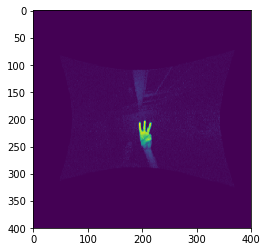

In [122]:
plt.imshow(data[53]['image'])
plt.show()

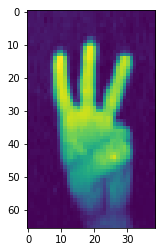

In [123]:
plt.imshow(data[53]['croppedImage'])
plt.show()

### Splitting the data

In [18]:
data_test = [data[0], data[1], data[20], data[21], data[50], data[51]]
test_ind = set((0,1,20,21,50,51))
data_train =  []
for i in range(54):
    if i not in test_ind:
        data_train.append(data[i])

### Splitting the Training Set Manually 

In [124]:
#Constructing Traning Data Set:
trainingExampleIndices = np.arange(0,40)
trainingExamples = [data_train[index] for index in trainingExampleIndices]
trainX, trainY = extractExamplesFromList(trainingExamples, dist = 4)

#Constructing Test Data Set:
testingExampleIndices = [40, 41, 42, 43, 44, 45, 46, 47]
testingExamples = [data_train[index] for index in testingExampleIndices]
testX, testY = extractExamplesFromList(testingExamples, dist = 4)


In [125]:
testing_y_fingernumbers = [data_train[index]['numFingers'] for index in testingExampleIndices]
print( 'True number of fingers in the test set ' + str(testing_y_fingernumbers) )


True number of fingers in the test set [3, 3, 3, 3, 3, 3, 3, 3]


# Decision Tree 

In [126]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
clf = clf.fit(trainX, trainY)
yHat = clf.predict(testX)

### Performance Evaluation 

In [127]:
DT_perf = clsf_Performance(y_hat=yHat, y_test=testY)

print ('Accuracy: '+ str(DT_perf.Accuracy()))
print ('Recall: '+ str(DT_perf.Recall()))
print ('Precision: '+ str(DT_perf.Precision()))
print ('AUC: '+ str(DT_perf.AUC()))




Accuracy: 0.960512168898
Recall: 0.61761487965
Precision: 0.911954765751
AUC: 0.805882678636


Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


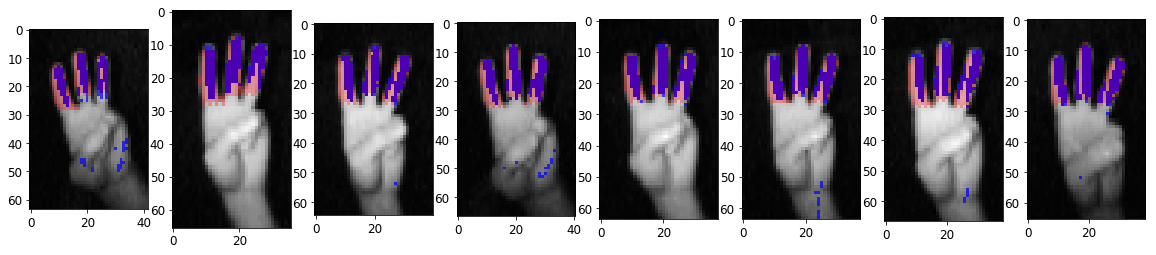

In [129]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers

plot_estimates_and_actuals(testingExampleIndices,yHat, testY, data_train) 

### Plotting Fitted images 

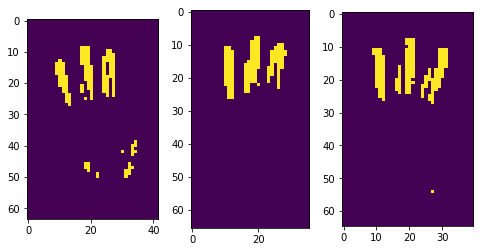

In [63]:
fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

### Grid Search for tuning the  max_depth hyper parameter

In [130]:
trainingExampleIndices = np.arange(0,48)
trainingExamples = [data_train[index] for index in trainingExampleIndices]
allX, allY = extractExamplesFromList(trainingExamples, dist = 4)


opt_dept, TCSL = cross_validation_for_Tree(allX, allY, k_fold = 5, max_depth=15)
print 'According to Grid Search optimum depth of the Decision tree is : ' + str(opt_dept)

('Cross-validation scores for max_depth = 3 (5-fold):', [0.478, 0.52, 0.5, 0.533, 0.547])
('Cross-validation scores for max_depth = 4 (5-fold):', [0.482, 0.594, 0.571, 0.606, 0.547])
('Cross-validation scores for max_depth = 5 (5-fold):', [0.573, 0.835, 0.84, 0.581, 0.626])
('Cross-validation scores for max_depth = 6 (5-fold):', [0.724, 0.835, 0.67, 0.821, 0.677])
('Cross-validation scores for max_depth = 7 (5-fold):', [0.732, 0.758, 0.778, 0.847, 0.791])
('Cross-validation scores for max_depth = 8 (5-fold):', [0.725, 0.799, 0.767, 0.756, 0.828])
('Cross-validation scores for max_depth = 9 (5-fold):', [0.725, 0.801, 0.782, 0.763, 0.832])
('Cross-validation scores for max_depth = 10 (5-fold):', [0.729, 0.877, 0.847, 0.833, 0.829])
('Cross-validation scores for max_depth = 11 (5-fold):', [0.772, 0.87, 0.881, 0.84, 0.899])
('Cross-validation scores for max_depth = 12 (5-fold):', [0.772, 0.848, 0.872, 0.818, 0.893])
('Cross-validation scores for max_depth = 13 (5-fold):', [0.777, 0.809, 0.

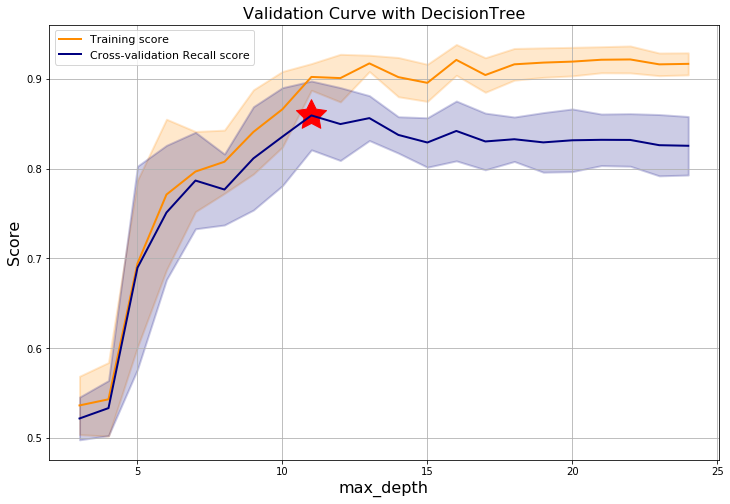

('Pick the parameter as : ', 11)


In [134]:
# Takes approx 1 min
fold_number = 5
scoring_metric = 'recall'
param_range = range(3,25)
plot_validation_curve(allX, allY, fold_number, param_range , scoring_metric)



In [132]:
# Using Pipeline to summerize the performance of Decision Tree 
from sklearn.pipeline import Pipeline


pipeRAWTree = Pipeline([ ('clf_tree', tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = opt_dept))])



trainingExampleIndices = np.arange(0,54)
trainingExamples = [data[index] for index in trainingExampleIndices]
allX, allY = extractExamplesFromList(trainingExamples, dist = 4)

Tree_cross_val_scorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5)

print"Cross Validation Accuracy Scores: ", list(Tree_cross_val_scorelist)
print'Classification Accuracy Scores Mean:', Tree_cross_val_scorelist.mean()
print'Classification Accuracy Scores Standart Deviation:', Tree_cross_val_scorelist.std()

Tree_cross_val_Recallscorelist = cross_val_score(pipeRAWTree, allX, allY, cv = 5, scoring = 'recall')

print "Cross Validation Recall Scores: ", list(Tree_cross_val_Recallscorelist)
print 'Classification Recall Scores Mean:', Tree_cross_val_Recallscorelist.mean()
print 'Classification Recall Scores Standart Deviation:', Tree_cross_val_Recallscorelist.std()




Cross Validation Accuracy Scores:  [0.97995052246796888, 0.98408595798102128, 0.98079976368939925, 0.97836121265832132, 0.98234924855064432]
Classification Accuracy Scores Mean: 0.981109341069
Classification Accuracy Scores Standart Deviation: 0.00196918903458
Cross Validation Recall Scores:  [0.7919375812743823, 0.88166449934980495, 0.87256176853055922, 0.84905660377358494, 0.90305790500975924]
Classification Recall Scores Mean: 0.859655671588
Classification Recall Scores Standart Deviation: 0.0380336422079


# Logistic Regression

In [135]:
from sklearn.linear_model import LogisticRegression

In [136]:
classifier = LogisticRegression(random_state=0)
classifier.fit (trainX, trainY)
y_hat_logi = classifier.predict(testX)

## Performance Evaluation

In [137]:
Logi_perf = clsf_Performance(y_hat= y_hat_logi, y_test=testY)

print ('Accuracy: '+ str(Logi_perf.Accuracy()))
print ('Recall: '+ str(Logi_perf.Recall()))
print ('Precision: '+ str(Logi_perf.Precision()))
print ('AUC: '+ str(Logi_perf.AUC()))




Accuracy: 0.959241520868
Recall: 0.596280087527
Precision: 0.919055649241
AUC: 0.795564107303


Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


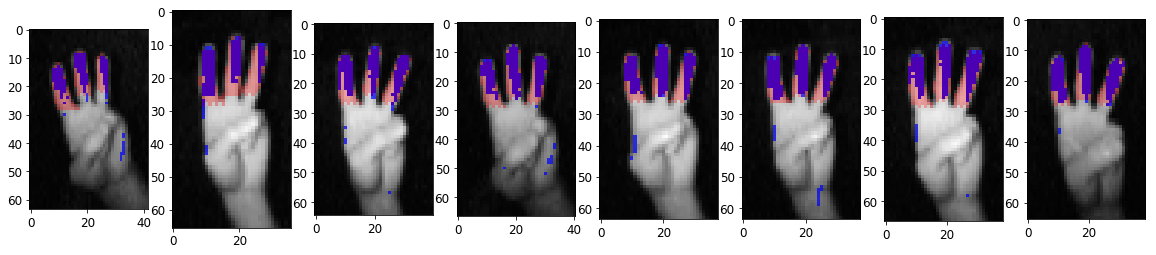

In [138]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_logi)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers


plot_estimates_and_actuals(testingExampleIndices,y_hat_logi, testY, data_train) 



## Plotting the examples from  fitted Images

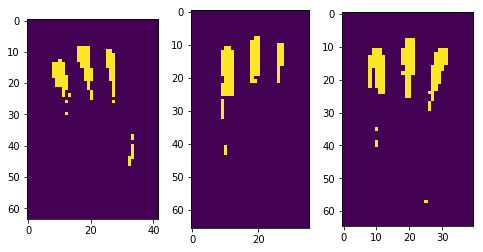

In [139]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_logi)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

In [140]:
trainingExampleIndices = np.arange(0,48)
trainingExamples = [data_train[index] for index in trainingExampleIndices]
allX, allY = extractExamplesFromList(trainingExamples, dist = 4)

In [141]:
# Pipeline implementation of Logistic Regression on Raw Data
from sklearn.pipeline import Pipeline


pipeRAWLogistic = Pipeline([ ('clf_log', LogisticRegression(random_state=0))])

Logistic_cross_val_scorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(Logistic_cross_val_scorelist))
print('Classification Accuracy Scores Mean:', Logistic_cross_val_scorelist.mean())
print('Classification Accuracy Scores Standart Deviation:', Logistic_cross_val_scorelist.std())

Logistic_cross_val_Recallscorelist =  cross_val_score(pipeRAWLogistic , allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(Logistic_cross_val_Recallscorelist))
print('Classification Recall Scores Mean:', Logistic_cross_val_Recallscorelist.mean())
print('Classification Recall Scores Standart Deviation:', Logistic_cross_val_Recallscorelist.std())


('Cross Validation Accuracy Scores: ', [0.97008812212982498, 0.97302552645732487, 0.97430805510736007, 0.96971577510239548, 0.97414042782076216])
('Classification Accuracy Scores Mean:', 0.97225558132353351)
('Classification Accuracy Scores Standart Deviation:', 0.0019751762178490543)
('Cross Validation Recall Scores: ', [0.76732312180889861, 0.70313639679066375, 0.69146608315098468, 0.64770240700218817, 0.63211678832116791])
('Classification Recall Scores Mean:', 0.68834895941478069)
('Classification Recall Scores Standart Deviation:', 0.047496320656059139)


# Random Forest 

In [142]:
from sklearn.ensemble import RandomForestClassifier

In [143]:
classifier_RF = RandomForestClassifier(n_estimators=2, criterion='entropy', random_state= 0, max_depth=5)
classifier_RF.fit(trainX, trainY)
y_hat_RF = classifier_RF.predict(testX)

## Performance Evaluation 

In [144]:
RF_perf = clsf_Performance(y_hat= y_hat_RF, y_test=testY)

print ('Accuracy: '+ str(RF_perf.Accuracy()))
print ('Recall: '+ str(RF_perf.Recall()))
print ('Precision: '+ str(RF_perf.Precision()))
print ('AUC: '+ str(RF_perf.AUC()))



Accuracy: 0.953376991496
Recall: 0.541575492341
Precision: 0.895117540687
AUC: 0.767675156281


Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


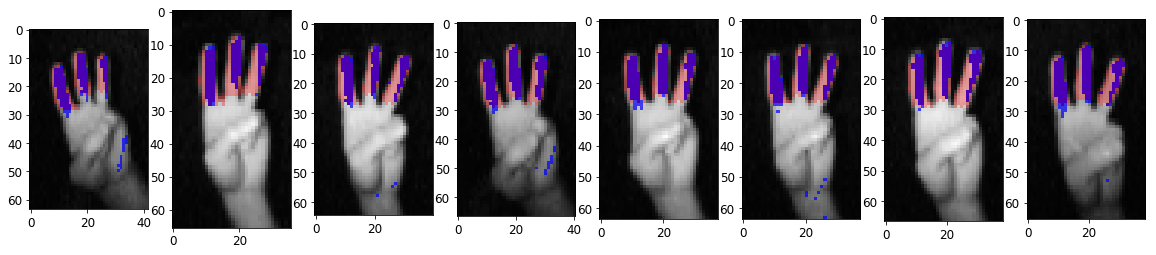

In [145]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_RF)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers

plot_estimates_and_actuals(testingExampleIndices,y_hat_RF, testY, data_train) 



## Plotting the Fitted Images

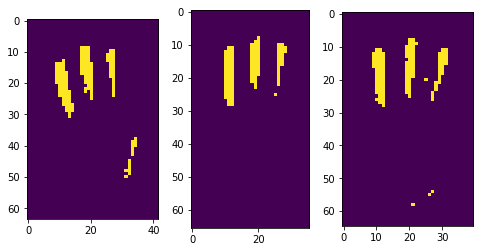

In [146]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_RF)

fig = plt.figure(0, (8, 4))
plt.subplot(1,3,1)
plt.imshow(Y_hat[0])
plt.subplot(1,3,2)
plt.imshow(Y_hat[1])
plt.subplot(1,3,3)
plt.imshow(Y_hat[2])
plt.show()

### CROSS VALIDATION of RANDOM FOREST MODEL

In [147]:
opt_forest_size, RFCSL = cross_validation_for_RandomForest_investigation(allX, allY, 5, 50)

('Cross-validation scores for n_estimators = 10 (5-fold):', [0.776, 0.85, 0.806, 0.813, 0.883])
('Cross-validation scores for n_estimators = 20 (5-fold):', [0.781, 0.849, 0.811, 0.82, 0.877])
('Cross-validation scores for n_estimators = 30 (5-fold):', [0.778, 0.83, 0.834, 0.818, 0.866])
('Cross-validation scores for n_estimators = 40 (5-fold):', [0.78, 0.827, 0.829, 0.816, 0.863])


In [148]:
print opt_forest_size

18


In [149]:
# Pipeline implementation of Random Forest to summerize Performance of RF Classifier


pipeRAWRandomForest = Pipeline([ ('classifier_RF', RandomForestClassifier(n_estimators=opt_forest_size, criterion='entropy', random_state= 0, max_depth=11))])

RF_cross_val_scorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(RF_cross_val_scorelist))
print('Classification Accuracy Scores Mean:', RF_cross_val_scorelist.mean())
print('Classification Accuracy Scores Standart Deviation:', RF_cross_val_scorelist.std())
RF_cross_val_Recallscorelist = cross_val_score(pipeRAWRandomForest  , allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(RF_cross_val_Recallscorelist))
print('Classification Recall Scores Mean:', RF_cross_val_Recallscorelist.mean())
print('Classification Recall Scores Standart Deviation:', RF_cross_val_Recallscorelist.std())

('Cross Validation Accuracy Scores: ', [0.9810516734930288, 0.98494063133507093, 0.98456828430764143, 0.98072069835753584, 0.98539451363316644])
('Classification Accuracy Scores Mean:', 0.98333516022528866)
('Classification Accuracy Scores Standart Deviation:', 0.0020193460059980844)
('Cross Validation Recall Scores: ', [0.78045222465353759, 0.85557986870897151, 0.83078045222465358, 0.8161925601750547, 0.88029197080291965])
('Classification Recall Scores Mean:', 0.83265941531302745)
('Classification Recall Scores Standart Deviation:', 0.034042579524331235)


# MLP

In [116]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(54,27,3))
mlp.fit(trainX , trainY)
y_hat_ANN = mlp.predict(testX)

## Performance Evaluation

In [117]:
MLP_perf = clsf_Performance(y_hat= y_hat_ANN, y_test=testY)

print ('Accuracy: '+ str(MLP_perf.Accuracy()))
print ('Recall: '+ str(MLP_perf.Recall()))
print ('Precision: '+ str(MLP_perf.Precision()))
print ('AUC: '+ str(MLP_perf.AUC()))



Accuracy: 0.979767373668
Recall: 0.864332603939
Precision: 0.904925544101
AUC: 0.927712078507


Predicted number of fingers in the test set :
[3, 3, 3, 3, 3, 3, 3, 3]
True number of fingers in the test set : 
[3, 3, 3, 3, 3, 3, 3, 3]


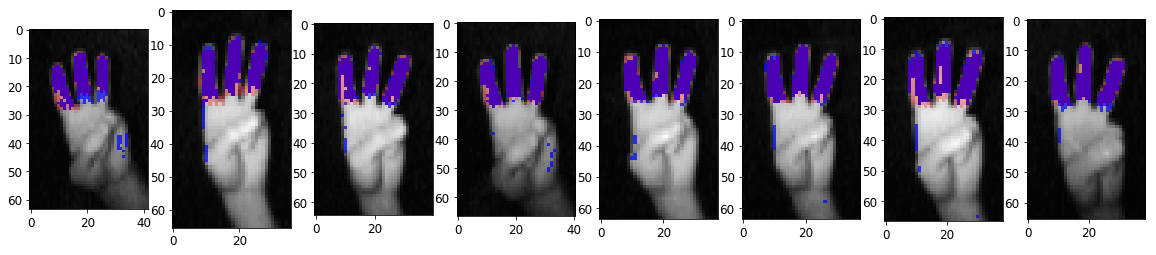

In [118]:
Y_hat = Reshape_to_yHatMatrix(testingExamples, y_hat_ANN)

print 'Predicted number of fingers in the test set :' 
print Y_hat_list_to_numFingers_list(Y_hat)
print 'True number of fingers in the test set : '
print testing_y_fingernumbers

plot_estimates_and_actuals(testingExampleIndices,y_hat_ANN, testY, data_train) 




In [120]:
pipeRAW_mlp = Pipeline([ ('mlp',MLPClassifier(hidden_layer_sizes=(54, 27,3)))])



mlp_cross_val_scorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5)

print("Cross Validation Accuracy Scores: ", list(mlp_cross_val_scorelist))
print('Accuracy Scores Mean:', mlp_cross_val_scorelist.mean())
print('Accuracy Scores Standart Deviation :', mlp_cross_val_scorelist.std())
mlp_cross_val_Recallscorelist = cross_val_score(pipeRAW_mlp, allX, allY, cv = 5, scoring = 'recall')

print("Cross Validation Recall Scores: ", list(mlp_cross_val_Recallscorelist))
print('Recall Scores Mean:', mlp_cross_val_Recallscorelist.mean())
print('Recall Scores Standart Deviation :', mlp_cross_val_Recallscorelist.std())

('Cross Validation Accuracy Scores: ', [0.98560258160605685, 0.98700922593190188, 0.9868437383641554, 0.976914484299367, 0.98390500227564237])
('Accuracy Scores Mean:', 0.98405500649542466)
('Accuracy Scores Standart Deviation :', 0.0037392241210156686)
('Cross Validation Recall Scores: ', [0.79066374908825676, 0.89277899343544853, 0.89059080962800874, 0.84390955506929244, 0.90948905109489053])
('Recall Scores Mean:', 0.8654864316631794)
('Recall Scores Standart Deviation :', 0.043302054614536706)


## DIRECT APPROACH

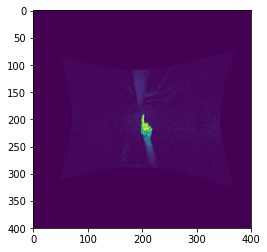

In [181]:
plt.imshow(data[0]['image'])
plt.show()

In [182]:
Xd= data[0]['image'].reshape((1, 400*400))
yd = [ data[0]['numFingers'] ]
for i in range(1,len(data)):
    b = data[i]['image'].reshape((1, 400*400))
    Xd = np.concatenate((Xd, b), axis=0)
    yd.append(data[i]['numFingers'])
yd = np.array(yd)

In [183]:
Xd_train = Xd[0:50,]
yd_train = yd[0:50]

Xd_test = Xd[51:54,]
yd_test = yd[51:54]

In [184]:
clf_dir = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 5)
clf_dir = clf_dir.fit(Xd_train, yd_train)
yHat_dir = clf_dir.predict(Xd_test)

In [185]:
yHat_dir

array([2, 1, 3])

In [194]:
mlp_dir = MLPClassifier(hidden_layer_sizes=(54, 27, 3), max_iter=200)
mlp_dir.fit(Xd_train , yd_train, )
y_hat_ANN_dir = mlp_dir.predict(Xd_test)
y_hat_ANN_dir

array([3, 3, 3])

# Cross Validation

In [212]:
x = np.array((1,2,5,6,6))
x

array([1, 2, 5, 6, 6])

In [ ]:
hcluster.fclusterdata()

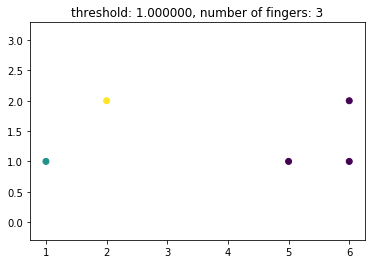

In [214]:
x = np.array((1,2,5,6,6))
y = np.array((1,2,1,1,2))
data_deneme  = np.column_stack((x,y))

thresh = 1
clusters = hcluster.fclusterdata(data_deneme, thresh, criterion="distance")

# plotting
plt.scatter(*np.transpose(data_deneme), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(clusters)))
plt.title(title)
plt.show()

In [ ]:
X_i = np.where(Y_hat[1] == 1)[0]
X_j = np.where(Y_hat[1] == 1)[1]

data_cl  = np.column_stack((X_i, X_j))
data_cl.shape

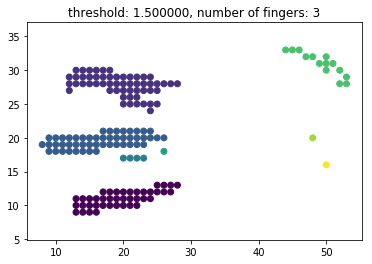

In [72]:
# clustering
thresh = 1.5
clusters = hcluster.fclusterdata(data_cl, thresh, criterion="distance")
#removing small clusters (caused by false positives)
new_clusters = remove_small_clusters(clusters,15)

# plotting
plt.scatter(*np.transpose(data_cl), c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()

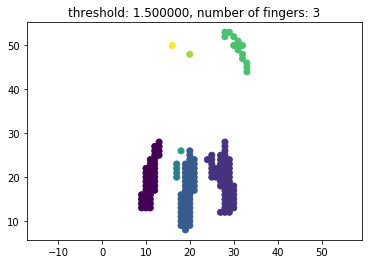

In [73]:
plt.scatter(np.array(data_cl)[:,1], np.array(data_cl)[:,0] , c=clusters)
plt.axis("equal")
title = "threshold: %f, number of fingers: %d" % (thresh, len(set(new_clusters)))
plt.title(title)
plt.show()



In [ ]:
def plots_estimates_and_actuals(testingExampleIndices,yHat, testY, data):
    """
    For given yHat(estimated), testY(actual), and test examples,
    it visualizes these in subplots.
    
    yHat and testY should be vectors 
    
    """
    fig = plt.figure(0, (8, 6))
    Y_hat = Reshape_to_yHatMatrix(testingExamples, yHat)
    Y_test = Reshape_to_yHatMatrix(testingExamples, testY)
    for i in range(len(testingExampleIndices)):
        
        fig.add_subplot(1,len(testingExampleIndices),i+1)
        imageDict = data[testingExampleIndices[i]]
        #im = makeGrayScale(imageDict)
        im = imageDict['croppedImage']
        im2 = im.copy()

        #Paint with matches:
        im[Y_test[i]==1] = [90]
        im2[Y_hat[i]==1] = 0
        
        
        
        plt.imshow(im2, interpolation = 'none')
        plt.imshow(im, interpolation = 'none', alpha = 0.3)
    plt.show()

In [ ]:
clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 11)
clf = clf.fit(X_cv, y_cv)
yHat = clf.predict(X_test_cv)

DT_perf = clsf_Performance(y_hat=yHat, y_test=y_test_cv)

print ('Accuracy: '+ str(DT_perf.Accuracy()))
print ('Recall: '+ str(DT_perf.Recall()))
print ('Precision: '+ str(DT_perf.Precision()))
print ('AUC: '+ str(DT_perf.AUC()))

# PRINTI UNUTMA 

In [ ]:
def max_depth_tuning(max_depth_list, trainX, trainY, testX):
    #max_depth_tuning
    tree_score_list = []
    for item in max_depth_list:
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        clf = clf.fit(trainX, trainY)
        yHat = clf.predict(testX)
        tree_score_list.append(("max_depth = "+str(item),clf.score(testX, testY)))
    return tree_score_list

In [ ]:
def max_depth_tuning_Recall(max_depth_list, trainX, trainY, testX):
    #max_depth_tuning
    tree_Recallscore_list = []
    for item in max_depth_list:
        clf = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = item)
        clf = clf.fit(trainX, trainY)
        yHat = clf.predict(testX)
        DT_perf = clsf_Performance(y_hat=yHat, y_test=testY)
        tree_Recallscore_list.append(("max_depth = "+str(item), "Recall: "+str(DT_perf.Recall())))
    return tree_Recallscore_list